In [1]:
def make_env(scenario_name, benchmark=False):
    '''
    Creates a MultiAgentEnv object as env. This can be used similar to a gym
    environment by calling env.reset() and env.step().
    Use env.render() to view the environment on the screen.
    Input:
        scenario_name   :   name of the scenario from ./scenarios/ to be Returns
                            (without the .py extension)
        benchmark       :   whether you want to produce benchmarking data
                            (usually only done during evaluation)
    Some useful env properties (see environment.py):
        .observation_space  :   Returns the observation space for each agent
        .action_space       :   Returns the action space for each agent
        .n                  :   Returns the number of Agents
    '''
    from multiagent.environment import MultiAgentEnv
    import multiagent.scenarios as scenarios

    # load scenario from script
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    # create world
    world = scenario.make_world()
    # create multiagent environment
    if benchmark:        
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation, scenario.benchmark_data)
    else:
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    return env

In [2]:
import sys
import gym
import gym.spaces
import pylab
import random
import tensorflow as tf
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from numpy.random import seed
from keras import backend as K
from keras.constraints import maxnorm,nonneg
from keras import regularizers


EPISODES = 50000
testing_episodes = 10000

episode_time = 30



# np.random.seed(123)
# random.seed(456)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# from keras import backend as K

# tf.set_random_seed(789)

# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)


# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.lam = 0
        self.alpha = 6
    

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.9
        self.actor_lr = 0.0005
        self.critic_lr = 0.0005
        
        self.critic2_lr = 0.0005

        # create model for policy network
        self.actor_1 = self.build_actor()
        self.actor_2 = self.build_actor()
        self.actor_3 = self.build_actor()
        
        self.critic = self.build_critic()
        self.critic2 = self.build_critic2()
        
#         self.target_critic = self.build_critic()
#         self.target_critic.set_weights(self.critic.get_weights())

#         self.target_critic2 = self.build_critic2()
#         self.target_critic2.set_weights(self.critic2.get_weights())

        
#         if self.load_model:
#             self.actor.load_weights("./save_model/cartpole_actor.h5")
#             self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(48, activation='relu'))
        #actor.add(Dense(24, activation='relu'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        #actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model 
    #Commented out kernel_constraint='nonneg' AND kernel_regularizer=regularizers.l2(0.0001) in critic and critic2 layes - all layers.
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(48, input_dim=self.state_size*3, activation='relu', 
                         kernel_initializer='he_uniform'))
        critic.add(Dense(48, activation='relu'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
    
    def build_critic2(self):
        critic = Sequential()
        critic.add(Dense(48, input_dim=self.state_size*3, activation='relu', 
                         kernel_initializer='he_uniform',kernel_constraint='nonneg'))
        critic.add(Dense(48, activation='relu',kernel_constraint='nonneg'))
        critic.add(Dense(self.value_size, activation='relu',
                         kernel_initializer='he_uniform',kernel_constraint='nonneg'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic2_lr))
        return critic
        

    # using the output of policy network, pick action stochastically
    def get_action_1(self, state):
        policy = self.actor_1.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_action_2(self, state):
        policy = self.actor_2.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_action_3(self, state):
        policy = self.actor_3.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    
    # update policy network every episode
    def train_model(self, state1,state2, state3, action1,action2,action3,reward1,reward2, next_state1,next_state2,next_state3, done):
        
        full_state = np.concatenate([state1,state2,state3],axis = 1)
        #print(np.shape(full_state))
        full_next_state = np.concatenate([next_state1,next_state2,next_state3], axis = 1)
        
        target = np.zeros((1, self.value_size))
        
        advantages_1 = np.zeros((1, self.action_size))
        advantages_2 = np.zeros((1, self.action_size))
        advantages_3 = np.zeros((1, self.action_size))
        
        target2 = np.zeros((1, self.value_size))     

        value = self.critic.predict(full_state)[0]
        value2 = self.critic2.predict(full_state)[0]
        next_value = self.critic.predict(full_next_state)[0]
        next_value2 = self.critic2.predict(full_next_state)[0]
        
        reward1 = reward1 + self.lam*(reward2)

        if done:
            advantages_1[0][action1] = -1*(reward1 - value)
            advantages_2[0][action2] = -1*(reward1- value)
            advantages_3[0][action3] = -1*(reward1- value)
            
            target[0][0] = reward1
            target2[0][0] = reward2
        else:
            advantages_1[0][action1] = -1*(reward1 + self.discount_factor * (next_value)- value)
            advantages_2[0][action2] = -1*(reward1 + self.discount_factor * (next_value)- value)
            advantages_3[0][action3] = -1*(reward1 + self.discount_factor * (next_value)- value)
            target[0][0] = reward1 + self.discount_factor * next_value
            target2[0][0] = reward2 + self.discount_factor * next_value2
#             if np.where(next_state == 1.0)[1][0] == self.target_state:
#                 target2[0][0] = 0 + self.discount_factor * next_value2
#             else:
#                 target2[0][0] = np.where(next_state == 1.0)[1][0]/10 + self.discount_factor * next_value2            
            

        self.actor_1.fit(state1, advantages_1, epochs=1, verbose=0)
        self.actor_2.fit(state2,advantages_2,epochs=1,verbose =0)
        self.actor_3.fit(state3,advantages_3,epochs=1,verbose =0)
        self.critic.fit(full_state, target, epochs=1, verbose=0)
        self.critic2.fit(full_state,target2,epochs = 1, verbose = 0)
        
    
        #self.lam = min(max(0,(self.lam + 0.005*(self.critic2.predict(full_state)[0] - self.alpha))), 5)
        #print(self.lam)
        
        
        
    def update_lambda(self,state1,state2,state3):
        
        full_state = np.concatenate([state1,state2,state3],axis = 1)
        self.lam = max(0,self.lam + 0.0001*(self.critic2.predict(full_state)[0] - self.alpha))
    
    
    
    
if __name__ == "__main__":
    
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v1')
    # get size of state and action from environment
    env = make_env('simple_spread')
    #print(env.observation_space.shape[0])
    state_size = 18 #env.observation_space.shape[0]
    action_size = 5 #env.action_space.n
    
    total_runs = 1
    median_penalties = np.zeros((1,total_runs))
    
    store_total_cost = np.zeros((1,EPISODES))
    store_total_penalty = np.zeros((1,EPISODES))
    store_lambda = np.zeros((1,EPISODES))
    
    #store_final_penalty = np.zeros((1,EPISODES))
    #average_final_count = np.zeros((1,total_runs))
    #total_count = 10000
    
    for runs in range(total_runs):
        
        
        np.random.seed((runs+1)*100)
        random.seed((runs+1)*110)

        session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        

        tf.set_random_seed((runs+1)*120)

        sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
        K.set_session(sess)
        
    
    
        agent = A2CAgent(state_size, action_size)
        
        scores, episodes = [], []

        for i in range(1):
            done = False
            score = 0
            #state = env.reset()
            pen_count = 0
            
            total_count = 0
            
            stop_count = 0
            
            #state = np.reshape(state, [1, state_size])
            #rand_state = random.randint(0,15)
            #state = np.zeros((1,state_size))
            #state[0][rand_state] = 1
            #state = np.reshape(state, [1, state_size])

            for e in range(EPISODES):
                
                state = env.reset()
                state1 = np.reshape(state[0], [1, state_size])
                state2 = np.reshape(state[1], [1, state_size])
                state3 = np.reshape(state[2], [1, state_size])
                
                
            
                epi_count = 0
                
                store_count  = 0
                
                agent.update_lambda(state1,state2,state3)

                #state = np.reshape(state, [1, state_size])
                for time in range(episode_time):
                
                    actions = []

                    action1 = agent.get_action_1(state1)
                    action2 = agent.get_action_2(state2)
                    action3 = agent.get_action_3(state3)
                    
                    
                    action_set1 = [0,0,0,0,0]
                    action_set2 = [0,0,0,0,0]
                    action_set3 = [0,0,0,0,0]

                    action_set1[action1] = 1
                    action_set2[action2] = 1
                    action_set3[action3] = 1

                    actions.append(action_set1)
                    actions.append(action_set2)
                    actions.append(action_set3)

                    #print(state1,state2)

                    #print(actions)

                    next_state, reward, done, _ = env.step(actions)

                    next_state1 = np.reshape(next_state[0], [1, state_size])
                    next_state2 = np.reshape(next_state[1], [1, state_size])
                    next_state3 = np.reshape(next_state[2], [1, state_size])
                    
                    #print(reward[0],reward[1],reward[2])

                    #print(reward[0])
                    
                    pen_reward = 0
                    temp_storage_reward = reward[0]
                    
                    
                    temp_reward2 = temp_storage_reward - 200
                    if temp_reward2 > 0:
                        #print("coming")
                        reward[0] = temp_reward2
                        pen_reward = 10
                    
                        
                    temp_reward = temp_storage_reward - 300
                    if temp_reward > 0:
                        #print("coming too")
                        reward[0] = temp_reward
                        pen_reward = 10
                        
                                
                    
                    store_count = store_count + (0.9**time)*reward[0]
                    
                    agent.train_model(state1,state2, state3, action1,action2,action3, reward[0], pen_reward,next_state1,next_state2,next_state3, done[0])
                    
                    
                    state1 = next_state1
                    state2 = next_state2
                    state3 = next_state3
                    
#                     if pen_reward > 0:
#                          epi_count= epi_count + 1
                            
                    epi_count = epi_count + (0.9**time)*(pen_reward/10)
        
                
                
                total_count = total_count + store_count
                store_total_cost[0][e] = total_count/(e+1)
                
            
                pen_count = pen_count + epi_count
                store_total_penalty[0][e] = pen_count/(e+1)
                
                store_lambda[0][e] = agent.lam
#                 print(e,total_count/(e+1),pen_count/(e+1),agent.lam)
                
#                 if np.remainder(e,10000) == 0:
#                     print(pen_count/(e+1))
                
                
            print(total_count/(e+1),pen_count/(e+1))

#Testing Begins

pen_count = 0
tot_count = 0
for test in range(testing_episodes):
    state = env.reset()
    
    state1 = np.reshape(state[0], [1, state_size])
    state2 = np.reshape(state[1], [1, state_size])
    state3 = np.reshape(state[2], [1, state_size])
    
    epi_count = 0
    rew_count = 0

    #state = np.reshape(state, [1, state_size])
    for time in range(episode_time):
        

        actions = []
        
        action1 = agent.get_action_1(state1)
        action2 = agent.get_action_2(state2)
        action3 = agent.get_action_3(state3)

        action_set1 = [0,0,0,0,0]
        action_set2 = [0,0,0,0,0]
        action_set3 = [0,0,0,0,0]

        action_set1[action1] = 1
        action_set2[action2] = 1
        action_set3[action3] = 1

        

        actions.append(action_set1)
        actions.append(action_set2)
        actions.append(action_set3)

        next_state, reward, done, _ = env.step(actions)

        next_state1 = np.reshape(next_state[0], [1, state_size])
        next_state2 = np.reshape(next_state[1], [1, state_size])
        next_state3 = np.reshape(next_state[2], [1, state_size])

        pen_reward = 0
        temp_storage_reward = reward[0]


        temp_reward2 = temp_storage_reward - 200
        if temp_reward2 > 0:
            #print("coming")
            reward[0] = temp_reward2  #+ 100
            pen_reward = 10

        temp_reward = temp_storage_reward - 300
        if temp_reward > 0:
            #print("coming too")
            reward[0] = temp_reward  #+ 100
            pen_reward = 10


        state1 = next_state1
        state2 = next_state2
        state3 = next_state3

        epi_count = epi_count + (0.9**time)*(pen_reward/10)
        rew_count = rew_count + (0.9**time)*reward[0]
        
        
    pen_count = pen_count + epi_count
    tot_count = tot_count + rew_count
    
print(tot_count/(test+1), pen_count/(test+1))

    
        

                    
        
    
        
        

/home/raghuram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


37.78414784083156 0.7006427291985186
33.61460604910976 0.6278939943118307


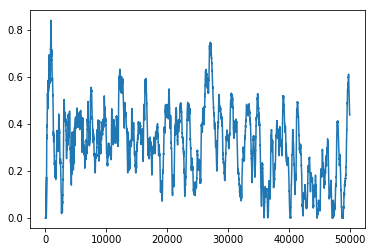

In [5]:
import matplotlib.pyplot as plt
# axes = plt.gca()
# axes.set_ylim([0.4,0.6])

plt.plot(store_lambda[0][0:e])

In [3]:
Check Carefully
np.savetxt('ss-Centralised-Cost-1',store_total_cost)
np.savetxt('ss-Centralised-Penalty-1',store_total_penalty)
np.savetxt('ss_lambda_1',store_lambda)

In [4]:

pen_count = 0
tot_count = 0
env = make_env('simple_spread')
for test in range(testing_episodes):
    state = env.reset()
    
    state1 = np.reshape(state[0], [1, state_size])
    state2 = np.reshape(state[1], [1, state_size])
    state3 = np.reshape(state[2], [1, state_size])
    
    epi_count = 0
    rew_count = 0

    #state = np.reshape(state, [1, state_size])
    for time in range(episode_time):
        
        env.render()
        actions = []
        
        action1 = agent.get_action_1(state1)
        action2 = agent.get_action_2(state2)
        action3 = agent.get_action_3(state3)

        action_set1 = [0,0,0,0,0]
        action_set2 = [0,0,0,0,0]
        action_set3 = [0,0,0,0,0]

        action_set1[action1] = 1
        action_set2[action2] = 1
        action_set3[action3] = 1

        

        actions.append(action_set1)
        actions.append(action_set2)
        actions.append(action_set3)

        next_state, reward, done, _ = env.step(actions)

        next_state1 = np.reshape(next_state[0], [1, state_size])
        next_state2 = np.reshape(next_state[1], [1, state_size])
        next_state3 = np.reshape(next_state[2], [1, state_size])

        pen_reward = 0
        temp_storage_reward = reward[0]


        temp_reward2 = temp_storage_reward - 200
        if temp_reward2 > 0:
            #print("coming")
            reward[0] = temp_reward2  #+ 100
            pen_reward = 10

        temp_reward = temp_storage_reward - 300
        if temp_reward > 0:
            #print("coming too")
            reward[0] = temp_reward  #+ 100
            pen_reward = 10


        state1 = next_state1
        state2 = next_state2
        state3 = next_state3

        epi_count = epi_count + (0.9**time)*(pen_reward/10)
        rew_count = rew_count + reward[0]
#     print(tot_count/(test+1), pen_count/(test+1))
        
        
    pen_count = pen_count + epi_count
    tot_count = tot_count + rew_count
    
    print(test,tot_count/(test+1), pen_count/(test+1))


agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
10 70.94442585308602 1.4144678116147842
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
12 68.76853940979338 1.1968573790586634
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
25 67.11105104454663 1.044952087489722
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

27 66.9342730217313 0.9914015812404561
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
40 68.29665936619065 0.989482198350173
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
55 67.536005374193 0.8879647916535421
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: 

57 67.02073602473112 0.864767164527558
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
68 66.09518057494395 0.943699508211255
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
70 65.58033370047451 0.9329182685433324
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
83 64.9239549563579 0.9165738382894786
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1:

85 64.22027662543078 0.9059359046994879
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
e